In [1]:
import sys
import numpy as np

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

sys.path.append("/home/aseliverstov/projects/brain_signals/experiments/src")
from src.dataset import EEG
from src.features import calculate_summary_features
from src.augmentations import augment_timeseries

2025-02-02 22:35:54.132540: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 22:35:54.139158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-02 22:35:54.161715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738524954.195266    2035 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738524954.203998    2035 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 22:35:54.236180: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
data_dir = Path("/home/aseliverstov/projects/brain_signals/dataset")
intencities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_channels = 31

dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels, image_name="Figs for spectra")

dataset.load_to_dataframe(users=[1], signals=["delta"])

# Model

In [23]:
def sample_timeseries_data(X, y, train_size = 3000, num_train = 1000, num_test = 500, train_end_idx = 10000, offset = 500, seed=None):
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.choice(len(X), num_train, replace=True)
    test_indices = np.random.choice(len(X), num_test, replace=True)

    slice_start = np.random.randint(0, train_end_idx - train_size, num_train)
    test_slice_start = np.random.randint(train_end_idx + offset, X.shape[1] - train_size + 1, num_test)

    X_train = np.array([X[i, start:start + train_size] for i, start in zip(indices, slice_start)])
    X_test = np.array([X[i, start:start + train_size] for i, start in zip(test_indices, test_slice_start)])

    y_train = y[indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test

[5157] [10735]


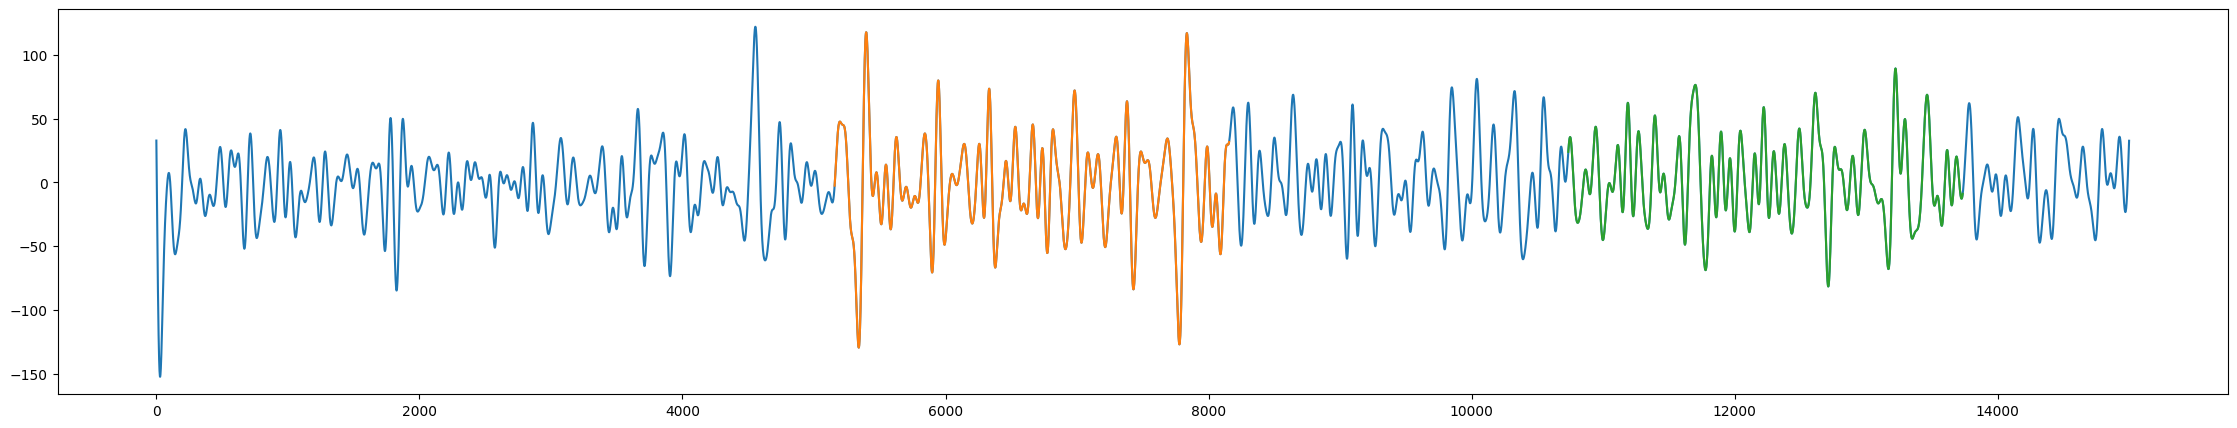

In [15]:
import matplotlib.pyplot as plt

X, y = dataset.X[0:1], dataset.y[0:1]
X_train, X_test, y_train, y_test = sample_timeseries_data(X, y, num_train=1, num_test=1, seed=1)

fig, ax = plt.subplots(1, 1, figsize=(28, 5))

ax.plot(np.arange(15000), X.T)
ax.plot(np.arange(5157, 8157), X_train.T)
ax.plot(np.arange(10735, 13735), X_test.T)

[2575] [10993]


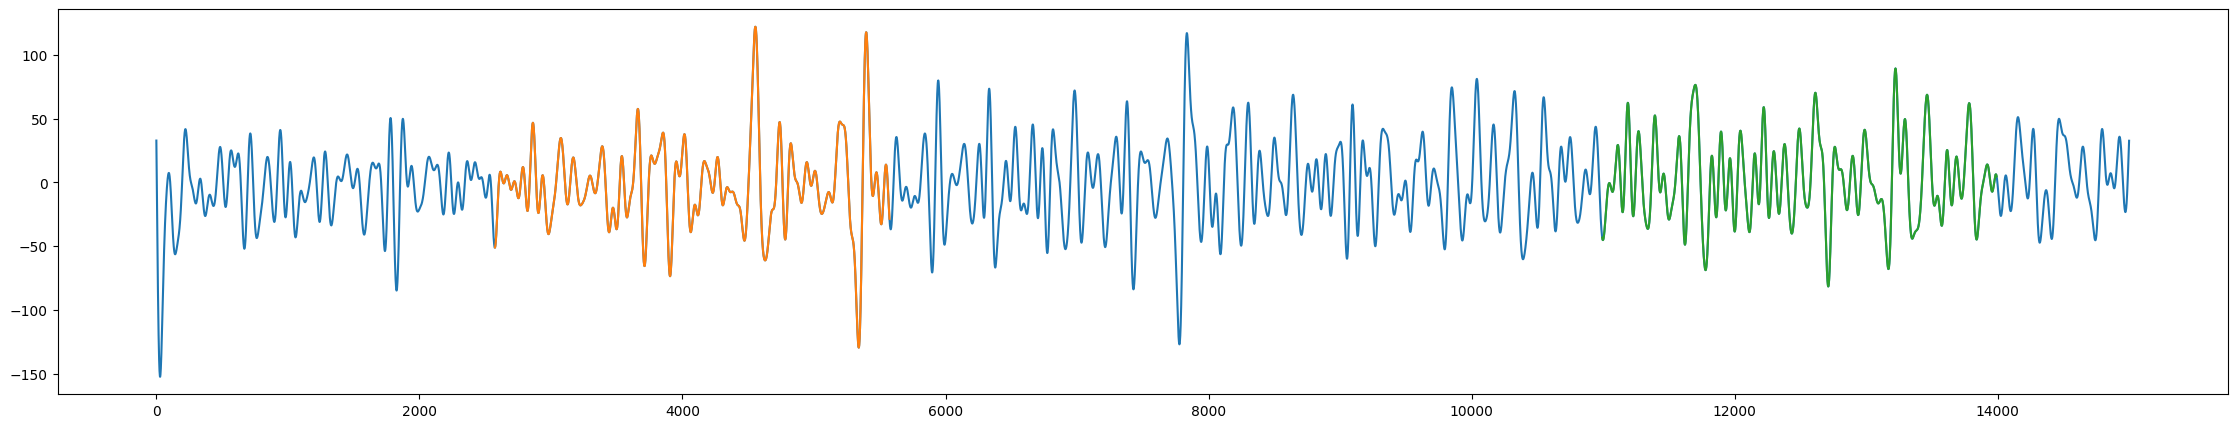

In [17]:
import matplotlib.pyplot as plt

X, y = dataset.X[0:1], dataset.y[0:1]
X_train, X_test, y_train, y_test = sample_timeseries_data(X, y, num_train=1, num_test=1, seed=2)

fig, ax = plt.subplots(1, 1, figsize=(28, 5))

ax.plot(np.arange(15000), X.T)
ax.plot(np.arange(2575, 2575 + 3000), X_train.T)
ax.plot(np.arange(10993, 10993 + 3000), X_test.T)

In [33]:
X, y = dataset.X, dataset.y
X_train, X_test, y_train, y_test = sample_timeseries_data(X, y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = calculate_summary_features(X_train, n_windows=3)
X_test = calculate_summary_features(X_test, n_windows=3)

X_train.shape

(1000, 18)

In [34]:
model = Sequential()
model.add(Dense(8, input_shape= (X_train.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer=Adam(learning_rate=0.1),
    loss=mse,
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10, batch_size=16, verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 719.5188 - val_loss: 0.1677
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1323 - val_loss: 0.0946
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0909 - val_loss: 0.0847
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0802 - val_loss: 0.0844
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0860 - val_loss: 0.0845
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0824 - val_loss: 0.0845
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0856 - val_loss: 0.0845
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0794 - val_loss: 0.0845
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0800 - val_loss: 0.0844
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0821 - val_loss: 0.0848


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,653 (272.09 KB)

 Trainable params: 23,217 (90.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 46,436 (181.39 KB)